In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product, islice
import h5py
import random

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [4]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [17]:
class RewardData(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
    
    def __getitem__(self, k):
        if k % 2 == 0:
            input = self.group['zeros-inputs'][k // 2]
            label = self.group['zeros-labels'][k // 2]
            return (input, label)
        else:
            input = self.group['ones-inputs'][k // 2]
            label = self.group['ones-labels'][k // 2]
            return (input, label)
    
    def __len__(self):
        return self.group['ones-labels'].shape[0] + self.group['zeros-labels'].shape[0]
    
    def close(self):
        self.f.close()
        
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [6]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()

def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()


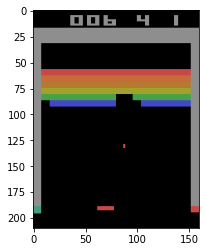

In [155]:
obs = env.reset()
for i in range(900):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

plt.imshow(env.get_images()[0])

In [156]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

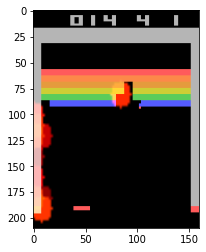

In [12]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
action, _states = model.predict(obs, deterministic=False)
obs, reward, done, info = env.step(action)

radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

In [26]:
def first_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    obs_copy[:, :, :, 1:4] = obs[:, :, :, 0:3]
    return obs_copy

def last_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    return obs_copy

In [27]:
def shaped_reward(rm, phi, obs, gamma=0.99):
    return rm(obs) + gamma*phi(last_three(obs)) - phi(first_three(obs))

In [29]:
def sum_pow(x, p=1/2):
    return th.sum(th.pow(th.abs(x), p))

def mean_pow(x, p=1/2):
    return th.mean(th.pow(th.abs(x), p))

def E_norm(x, p=1/2):
    return th.pow(mean_pow(x, p), 1/p)

In [29]:
phi = RewardModel(env, device)

In [30]:
with th.no_grad():
    print(rm(obs))
    print(shaped_reward(rm, phi, obs))

tensor([[0.6907]], device='cuda:0')
tensor([[0.6826]], device='cuda:0')


In [31]:
train = RewardData(train=True)
test = RewardData(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [32]:
optimizer = th.optim.Adam(phi.parameters())

In [36]:
spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.3672, device='cuda:0')


In [37]:
num_batches = 0
for samples, targets in tqdm(train_loader):
    optimizer.zero_grad()
    loss = E_norm(shaped_reward(rm, phi, samples))
    loss.backward()
    optimizer.step()
    num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [38]:
spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.1881, device='cuda:0')


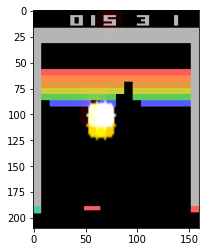

In [39]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
action, _states = model.predict(obs, deterministic=False)
obs, reward, done, info = env.step(action)

radius = 5
stride = 4

reward_model = lambda obs: shaped_reward(rm, phi, obs)
pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

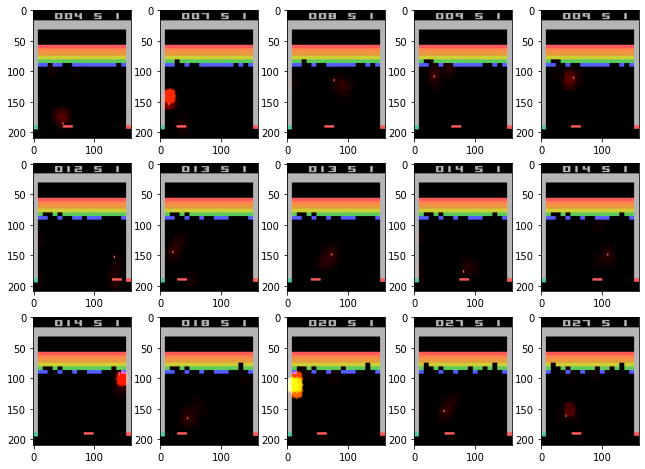

In [44]:
plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 15

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(3, N//3, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

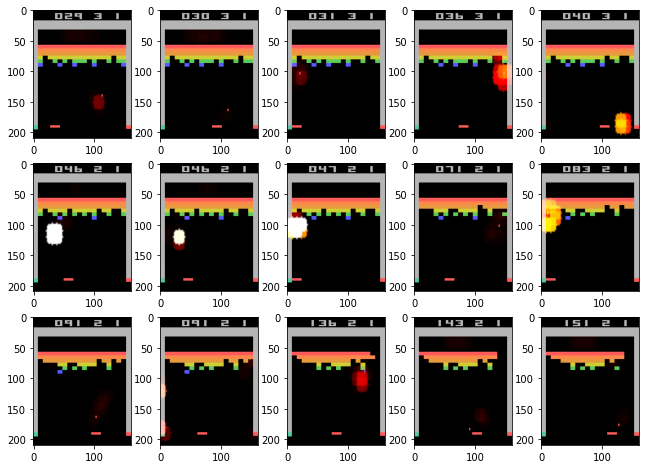

In [45]:
plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 15

reward_model = lambda obs: shaped_reward(rm, phi, obs)
obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(3, N//3, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        # max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

In [47]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


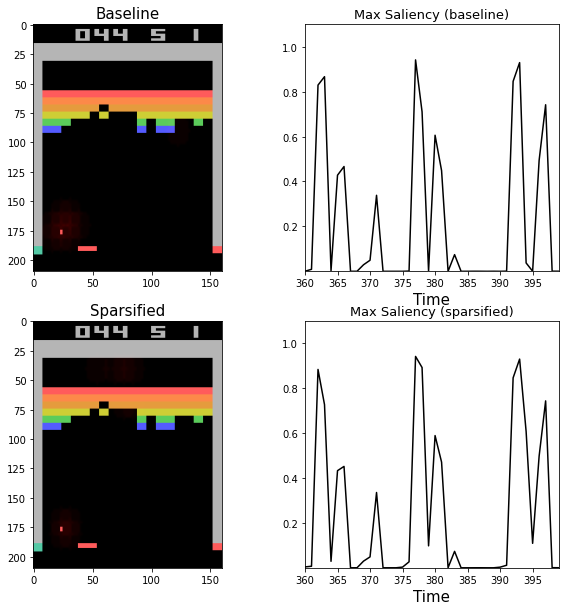

In [53]:
radius = 5
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ((ax1v, ax1t), (ax2v, ax2t)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 10))

ax1t.set_xlabel("Time", fontsize=15)
ax1t.set_title("Max Saliency (baseline)", fontsize=13)
ax2t.set_xlabel("Time", fontsize=15)
ax2t.set_title("Max Saliency (sparsified)", fontsize=13)

ax1v.set_title("Baseline", fontsize=15)
ax2v.set_title("Sparsified", fontsize=15)

imshow1 = ax1v.imshow(env.get_images()[0])
timeseries1 = ax1t.plot([], [], c='black')[0]

imshow2 = ax2v.imshow(env.get_images()[0])
timeseries2 = ax2t.plot([], [], c='black')[0]

reward_model = lambda obs: shaped_reward(rm, phi, obs)
obs = env.reset()
max_saliencies1 = []
max_saliencies2 = []
with writer.saving(fig, "../videos/sparsification/breakout_reward_model_saliency_baseline.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        screenshot_saved = env.get_images()[0]
        # Baseline (1)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies1.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow1.set_data(screenshot)
        ax1t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax1t.set_ylim(0.0001, 1.1)
        timeseries1.set_data(list(range(i+1))[-40:], max_saliencies1[-40:])
        
        # Sparsified (2)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies2.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow2.set_data(screenshot)
        ax2t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2t.set_ylim(0.0001, 1.1)
        timeseries2.set_data(list(range(i+1))[-40:], max_saliencies2[-40:])
        writer.grab_frame()


# Not much of a difference. Let's see about sparsifying a noisy reward model now

In [164]:
def shaped_reward(rm, phi, obs, gamma=0.99):
    return rm(obs) + gamma*phi(last_three(obs)) - phi(first_three(obs))

In [165]:
rm_noise = RewardModel(env, device)

predicted_rewards = []
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    predicted_rewards.append(rm_noise(obs).item())
    if done:
        break
predicted_rewards = np.array(predicted_rewards)

m, s = predicted_rewards.mean(), predicted_rewards.std()

def shaped(x):
    return (x - m) * 1/s

In [166]:
alpha = 0.5

rm_noisy = lambda obs: rm(obs) + alpha*shaped(rm_noise(obs))
phi = lambda obs: 0

## Take baseline norm

In [167]:
phi = lambda obs: 0

spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.3592, device='cuda:0')


## Noisy norm

In [168]:
phi = lambda obs: 0

spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm_noisy, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.6242, device='cuda:0')


## Let's now sparsify

In [169]:
phi = RewardModel(env, device)
optimizer = th.optim.Adam(phi.parameters())

In [170]:
num_batches = 0
for _ in tqdm(range(1)):
    for samples, targets in train_loader:
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rm_noisy, phi, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [171]:
spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm_noisy, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.3962, device='cuda:0')


## Alright so it did manage to sparsify it back to the pre-noise level, but not yet all the way down to baseline. Let's see whether this changes interpretability.

### Noisy:

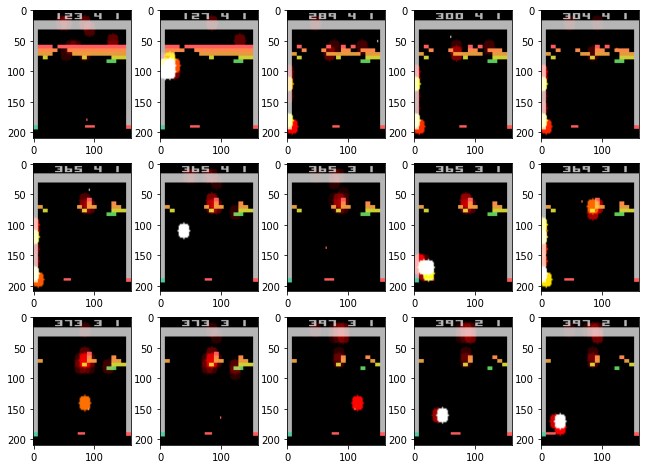

In [175]:
plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 15

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(3, N//3, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm_noisy, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

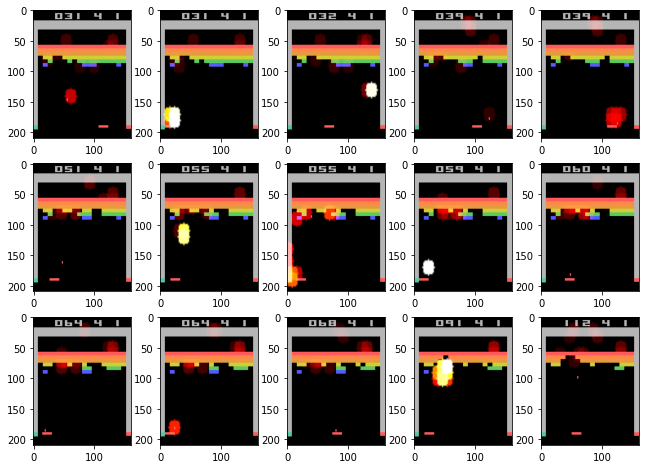

In [174]:
plt.figure(figsize=(11, 8))

radius = 5
stride = 4
k = 0
N = 15

reward_model = lambda obs: shaped_reward(rm_noisy, phi, obs)

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if random.randint(0, 50) == 0:
        plt.subplot(3, N//3, k+1)
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        plt.imshow(screenshot)
        k += 1
    if k == N:
        break

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


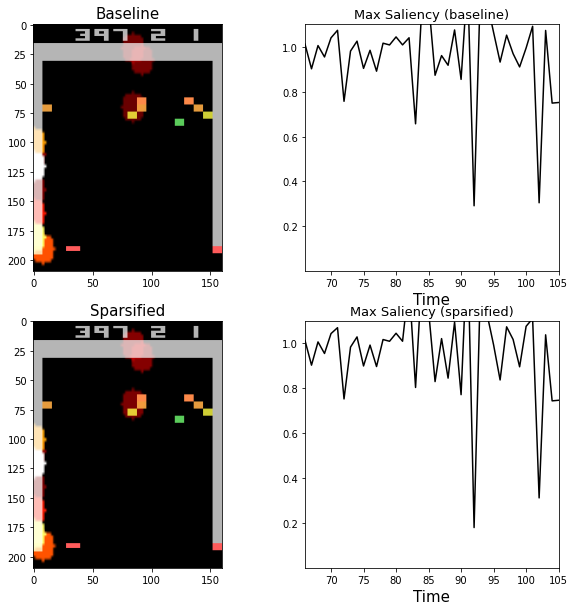

In [176]:
radius = 5
stride = 4

TIMESTEPS = 150

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ((ax1v, ax1t), (ax2v, ax2t)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 10))

ax1t.set_xlabel("Time", fontsize=15)
ax1t.set_title("Max Saliency (baseline)", fontsize=13)
ax2t.set_xlabel("Time", fontsize=15)
ax2t.set_title("Max Saliency (sparsified)", fontsize=13)

ax1v.set_title("Baseline", fontsize=15)
ax2v.set_title("Sparsified", fontsize=15)

imshow1 = ax1v.imshow(env.get_images()[0])
timeseries1 = ax1t.plot([], [], c='black')[0]

imshow2 = ax2v.imshow(env.get_images()[0])
timeseries2 = ax2t.plot([], [], c='black')[0]

reward_model = lambda obs: shaped_reward(rm_noisy, phi, obs)
obs = env.reset()
max_saliencies1 = []
max_saliencies2 = []
with writer.saving(fig, "../videos/sparsification/breakout_noisy_reward_model_saliency_comparison.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        screenshot_saved = env.get_images()[0]
        # Baseline (1)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm_noisy, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies1.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow1.set_data(screenshot)
        ax1t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax1t.set_ylim(0.0001, 1.1)
        timeseries1.set_data(list(range(i+1))[-40:], max_saliencies1[-40:])
        
        # Sparsified (2)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies2.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow2.set_data(screenshot)
        ax2t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2t.set_ylim(0.0001, 1.1)
        timeseries2.set_data(list(range(i+1))[-40:], max_saliencies2[-40:])
        writer.grab_frame()


## Okay so sparsifying didn't really eliminate the noise well. Let's be more aggressive with the sparsification.

In [184]:
alpha = 0.5

rm_noisy = lambda obs: rm(obs) + alpha*shaped(rm_noise(obs))
phi = lambda obs: 0

### baseline norm

In [185]:
phi = lambda obs: 0

spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm, phi, samples), p=1/4)
        outof += len(samples)
print(th.pow(spow/outof, 4))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.2101, device='cuda:0')


### noisy norm

In [186]:
phi = lambda obs: 0

spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm_noisy, phi, samples), p=1/4)
        outof += len(samples)
print(th.pow(spow/outof, 4))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.5597, device='cuda:0')


In [187]:
phi = RewardModel(env, device)
optimizer = th.optim.Adam(phi.parameters())

In [188]:
num_batches = 0
for _ in tqdm(range(1)):
    for samples, targets in train_loader:
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rm_noisy, phi, samples), p=1/4)
        loss.backward()
        optimizer.step()
        num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [189]:
spow = 0
outof = 0
for samples, targets in tqdm(test_loader):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rm_noisy, phi, samples), p=1/4)
        outof += len(samples)
print(th.pow(spow/outof, 4))

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(0.4397, device='cuda:0')


/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


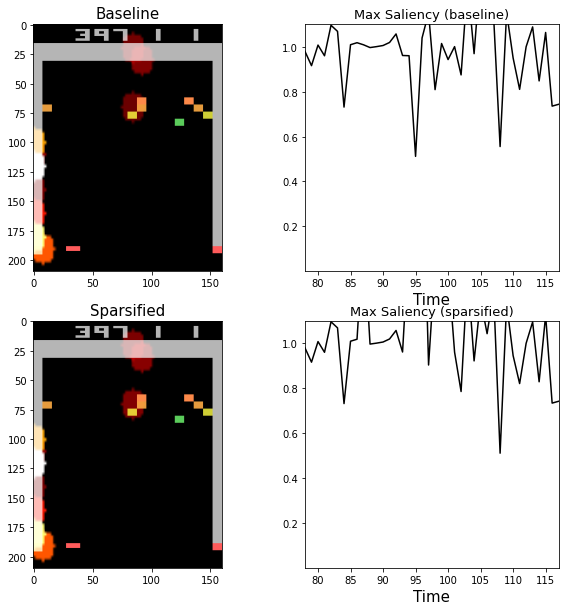

In [190]:
radius = 5
stride = 4

TIMESTEPS = 150

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ((ax1v, ax1t), (ax2v, ax2t)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 10))

ax1t.set_xlabel("Time", fontsize=15)
ax1t.set_title("Max Saliency (baseline)", fontsize=13)
ax2t.set_xlabel("Time", fontsize=15)
ax2t.set_title("Max Saliency (sparsified)", fontsize=13)

ax1v.set_title("Baseline", fontsize=15)
ax2v.set_title("Sparsified", fontsize=15)

imshow1 = ax1v.imshow(env.get_images()[0])
timeseries1 = ax1t.plot([], [], c='black')[0]

imshow2 = ax2v.imshow(env.get_images()[0])
timeseries2 = ax2t.plot([], [], c='black')[0]

reward_model = lambda obs: shaped_reward(rm_noisy, phi, obs)
obs = env.reset()
max_saliencies1 = []
max_saliencies2 = []
with writer.saving(fig, "../videos/sparsification/breakout_noisy_1_4_sparsified_reward_model_saliency_comparison.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        screenshot_saved = env.get_images()[0]
        # Baseline (1)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm_noisy, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies1.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow1.set_data(screenshot)
        ax1t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax1t.set_ylim(0.0001, 1.1)
        timeseries1.set_data(list(range(i+1))[-40:], max_saliencies1[-40:])
        
        # Sparsified (2)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies2.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow2.set_data(screenshot)
        ax2t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2t.set_ylim(0.0001, 1.1)
        timeseries2.set_data(list(range(i+1))[-40:], max_saliencies2[-40:])
        writer.grab_frame()


# It still doesn't seem like sparsifying removes noise

# Let's sparsify a DRLHP reward model now!

## Switch environment to Pong

In [18]:
env_id = "PongNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [19]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [20]:
class RewardData(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
    
    def __getitem__(self, k):
        if k % 2 == 0:
            input = self.group['zeros-inputs'][k // 2]
            label = self.group['zeros-labels'][k // 2]
            return (input, label)
        else:
            input = self.group['ones-inputs'][k // 2]
            label = self.group['ones-labels'][k // 2]
            return (input, label)
    
    def __len__(self):
        return self.group['ones-labels'].shape[0] + self.group['zeros-labels'].shape[0]
    
    def close(self):
        self.f.close()

In [6]:
import logging

sys.path.insert(1, "/home/eric/Code/chai/test/learning-from-human-preferences")
sys.path.insert(2, "/home/eric/Code/chai/test/learning-from-human-preferences/drlhp")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import easy_tf_log
#     from drlhp import reward_predictor
    from drlhp.reward_predictor_core_network import net_cnn
    from drlhp.HumanPreferencesEnvWrapper import _make_reward_predictor

In [7]:
ckpt_dir = Path('/home/eric/Code/chai/test/learning-from-human-preferences/runs/pong_45cb953/reward_predictor_checkpoints')
log_dir = Path('logs')
logger = logging.getLogger("testytest")

obs_shape = (84, 84, 4)

In [8]:
rp = _make_reward_predictor(reward_predictor_network=net_cnn,
                           log_dir=log_dir,
                           obs_shape=obs_shape,
                           logger=logger,
                           checkpoint_dir=ckpt_dir)

RewardPredictorEnsemble created
RewardPredictorEnsemble initialized


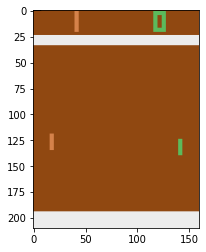

In [21]:
obs = env.reset()
for i in range(900):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
    
plt.imshow(env.get_images()[0])

In [22]:
def shaped_reward(reward_model, phi, obs, gamma=0.99):
    return th.tensor(reward_model.reward(obs.detach().numpy())).to(device) + gamma*phi(last_three(obs)) - phi(first_three(obs))


In [23]:
train = RewardData(train=True)
test = RewardData(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

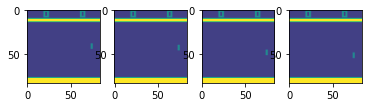

In [24]:
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(train[10][0][:, :, k])

In [25]:
def first_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    obs_copy[:, :, :, 1:4] = obs[:, :, :, 0:3]
    return obs_copy

def last_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    return obs_copy

In [26]:
def sum_pow(x, p=1/2):
    return th.sum(th.pow(th.abs(x), p))

def mean_pow(x, p=1/2):
    return th.mean(th.pow(th.abs(x), p))

def E_norm(x, p=1/2):
    return th.pow(mean_pow(x, p), 1/p)

### Baseline sparsity

In [27]:
phi = lambda obs: 0

spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rp, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))


tensor(0.0266, device='cuda:0')


### Sparsify for one epoch

In [28]:
phi = RewardModel(env, device)
optimizer = th.optim.Adam(phi.parameters(), lr=1e-5)

In [29]:
num_batches = 0
for _ in range(1):
    for samples, targets in tqdm(train_loader):
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rp, phi, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

In [48]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():    
        spow += sum_pow(shaped_reward(rp, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2))


tensor(nan, device='cuda:0')


In [ ]:
radius = 5
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ((ax1v, ax1t), (ax2v, ax2t)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 10))

ax1t.set_xlabel("Time", fontsize=15)
ax1t.set_title("Max Saliency (baseline)", fontsize=13)
ax2t.set_xlabel("Time", fontsize=15)
ax2t.set_title("Max Saliency (sparsified)", fontsize=13)

ax1v.set_title("Baseline", fontsize=15)
ax2v.set_title("Sparsified", fontsize=15)

imshow1 = ax1v.imshow(env.get_images()[0])
timeseries1 = ax1t.plot([], [], c='black')[0]

imshow2 = ax2v.imshow(env.get_images()[0])
timeseries2 = ax2t.plot([], [], c='black')[0]

reward_model = lambda obs: shaped_reward(rp, phi, obs)
obs = env.reset()
max_saliencies1 = []
max_saliencies2 = []
with writer.saving(fig, "../videos/sparsification/pong_reward_model_saliency_comparison.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        screenshot_saved = env.get_images()[0]
        # Baseline (1)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies1.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow1.set_data(screenshot)
        ax1t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax1t.set_ylim(0.0001, 1.1)
        timeseries1.set_data(list(range(i+1))[-40:], max_saliencies1[-40:])
        
        # Sparsified (2)
        screenshot = np.copy(screenshot_saved)
        screenshot = screenshot / screenshot.max()
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
        max_value = pairs[0][1]
        max_saliencies2.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow2.set_data(screenshot)
        ax2t.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
        ax2t.set_ylim(0.0001, 1.1)
        timeseries2.set_data(list(range(i+1))[-40:], max_saliencies2[-40:])
        writer.grab_frame()
